In [1]:
#import and magics
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import json
import hackathon_params as hp

hp.hackParams(10,200)   #this method creates a json file with dictionary of parameters {N, steps}

In [1]:
%%writefile benchmark1a.py

import sympy
import fipy as fp
import numpy as np
import sys
import os
import resource
import json
from fipy.solvers.pysparse import LinearLUSolver as Solver

memory1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss #get initial memory peak

#load in the json parameter file here
jsonfile = sys.argv[1]

if jsonfile:
    with open(jsonfile, 'rb') as ff:
        params = json.load(ff)
        
else:
    params = dict()
    
print 'my params:', params

#extract the parameters
N= params.get('N', 20)
total_steps = params.get('steps', 2)
sumatra_label = params.get('sumatra_label', '')

c, rho_s, c_alpha, c_beta = sympy.symbols("c_var rho_s c_alpha c_beta")
f_0 = rho_s * (c - c_alpha)**2 * (c_beta - c)**2

mesh = fp.PeriodicGrid2D(nx=N, ny=N, dx=1.0, dy=1.0)

c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
M = 5.0
c_0 = 0.5
epsilon = 0.01
rho_s = 5.0
filepath = os.path.join('Data', sumatra_label)

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

x , y = np.array(mesh.x), np.array(mesh.y)

out = sympy.diff(f_0, c, 2)

exec "f_0_var = " + repr(out)
#f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
def f_0_var(c_var):
    return 2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)
f_data = []
time_data = []

def save_data(f, time):
    f_data.append(f.value)
    time_data.append(time)
    np.savetxt(os.path.join(filepath, '1a.txt'), zip(time_data, f_data))
    
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(M * f_0_var(c_var)) - fp.DiffusionTerm((M, kappa))

elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
# duration = 1000.0

c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))
c_var.updateOld()
solver = Solver()

while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

    if (res < (res0 * tolerance)):
        steps += 1
#       elapsed += dt
        dt *= 1.1
        c_var.updateOld()

        if (steps%(total_steps/10.0)==0):
            # record the volume integral of the free energy 
            save_data(f_0_var(c_var).cellVolumeAverage*mesh.numberOfCells, elapsed)
            # pickle the data on c as a function of space at this particular time
            fp.dump.write({'time' : steps, 'var': c_var}, os.path.join(filepath,'1a{0}.pkl'.format(steps)))
                          
    else:
        dt *= 0.8
        c_var[:] = c_var.old

print 'elapsed_time:',elapsed

#memory stuff saves
filepath = os.path.join('Data', sumatra_label)
#Keep track os how much memory was used and dump into a txt file
memory2 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss #final memory peak
memory_diff = (memory2 - memory1,)
filename2 = 'memory_usage.txt'
np.savetxt(os.path.join(filepath, filename2), memory_diff )

Overwriting benchmark1a.py


In [39]:
!mkdir Data
!mkdir 1apickles

mkdir: cannot create directory ‘Data’: File exists


In [40]:
!python  benchmark1a.py params.json

my params: {u'steps': 200, u'N': 10}
20
0.572749994933
40
4.42592555682
60
30.3481639541
80
99.0317029596
100
221.843418107
120
428.677971403
140
873.517578825
elapsed_time: 1012.40585203


In [42]:
!git log -1

commit faf22d7ffb95c9de3a8406b383274fb32ebf162c
Author: Anushka Dasgupta <anushkad@princeton.edu>
Date:   Wed Jun 8 16:32:10 2016 -0400

    benchmark problem 1a ready for sumatra


In [44]:
%%bash

rm -rf .smt
smt init benchmark1
smt configure --executable=python --main=benchmark1a.py
smt configure --launch_mode=serial
smt configure -g uuid
smt configure -c store-diff
smt configure --addlabel=parameters

Sumatra project successfully set up
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly


In [2]:
import itertools
import hackathon_params as hp

N=(10, 15, 40, 100)
steps=(2, 10, 20)
tag='benchmark1a'

for N, steps in itertools.product(N, steps):
    hp.hackParams(N,steps)
    !smt run params.json --tag=$tag

my params: {u'N': 10, u'steps': 2, u'sumatra_label': u'340892a6cfa2'}
elapsed_time: 0.0
Record label for this run: '340892a6cfa2'
Data keys are [memory_usage.txt(36fc2be4114e058f601465e625477fb73077853e [2016-06-09 10:44:46])]
my params: {u'N': 10, u'steps': 10, u'sumatra_label': u'56856a679b0c'}
elapsed_time: 0.0
Record label for this run: '56856a679b0c'
Data keys are [1a.txt(342e2b6b4bf84a2f5705327101ddd11dbe6e5da8 [2016-06-09 10:47:05]), 1a1.pkl(7b45fa78fe3329c20e510e87fa95d9734a6fc1c2 [2016-06-09 10:47:03]), 1a2.pkl(1659ce39c0b32cff76a556f0c77261f44e27497b [2016-06-09 10:47:03]), 1a3.pkl(8b52b3889aac4257f0f8269e330a60ae62a91c5f [2016-06-09 10:47:03]), 1a4.pkl(5207031c76b64c18dbc61d600f5787bb1d901ba7 [2016-06-09 10:47:03]), 1a5.pkl(c0f9fdeae084c0b79898939dbcb9b6e88b9d6d31 [2016-06-09 10:47:04]), 1a6.pkl(2c3ee43931b95bd302259ea458fc8f1d89952e7c [2016-06-09 10:47:04]), 1a7.pkl(852667b5db0f5af30432360e4222a73678ae2f39 [2016-06-09 10:47:04]), 1a8.pkl(a8d04cca8bf7cd8fd04ebb5b09954fba4c3c

In [2]:
# del df
print df

NameError: name 'df' is not defined

In [3]:
import json
import pandas

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)

In [4]:
print df['output_data'][0]

[{u'path': u'1a.txt', u'creation': u'2016-06-09 11:03:00', u'digest': u'742b13bb765786539047736f3520aaf869fbd785', u'metadata': {u'mimetype': u'text/plain', u'size': 510, u'encoding': None}}, {u'path': u'1a10.pkl', u'creation': u'2016-06-09 11:02:28', u'digest': u'3ec122c25a8a28e1146d2c54fea77b94e2d5935c', u'metadata': {u'mimetype': None, u'size': 180021, u'encoding': None}}, {u'path': u'1a12.pkl', u'creation': u'2016-06-09 11:02:31', u'digest': u'1fb60e7d78eb1c708a45841d462d5042c27d7512', u'metadata': {u'mimetype': None, u'size': 179969, u'encoding': None}}, {u'path': u'1a14.pkl', u'creation': u'2016-06-09 11:02:35', u'digest': u'0542c96be05816912dd63844a8b277ee731640da', u'metadata': {u'mimetype': None, u'size': 179641, u'encoding': None}}, {u'path': u'1a16.pkl', u'creation': u'2016-06-09 11:02:53', u'digest': u'4a9124cb0eaeff634aacf4d03e4414e6ea1d1082', u'metadata': {u'mimetype': None, u'size': 179886, u'encoding': None}}, {u'path': u'1a18.pkl', u'creation': u'2016-06-09 11:02:57', 

In [5]:
print df[['label', 'duration']]

           label   duration
0   fb05af6afdcf  56.254625
1   3192bf46d7d7  40.805019
2   3732ce888743   4.715544
3   a0018504b67e   9.645944
4   1c829f035167   7.552931
5   9583f5b980e2   2.330763
6   c5d2101501d5   7.207196
7   a344c29547b8  11.036295
8   a770dc5c0f36   2.255785
9   97ba89e932a8   8.626628
10  56856a679b0c   4.824381
11  340892a6cfa2   2.283088


In [6]:
df['parameters'][0]['content']

u'{\n    "N": 100, \n    "steps": 20, \n    "sumatra_label": "fb05af6afdcf"\n}'

In [7]:
import json
df = df.copy()
df['nproc'] = 1 # We are running in serial
for p in 'N', 'steps':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])


In [52]:
df

,datastore,dependencies,diff,duration,executable,input_data,input_datastore,label,launch_mode,main_file,...,repository,script_arguments,stdout_stderr,tags,timestamp,user,version,nproc,N,steps
0,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,56.254625,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",fb05af6afdcf,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 100, u'steps': 20, u'sumatra...",[benchmark1a],2016-06-09 11:01:49,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,100,20
1,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,40.805019,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",3192bf46d7d7,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 100, u'steps': 10, u'sumatra...",[benchmark1a],2016-06-09 11:00:14,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,100,10
2,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,4.715544,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",3732ce888743,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 100, u'steps': 2, u'sumatra_...",[benchmark1a],2016-06-09 10:59:06,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,100,2
3,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,9.645944,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",a0018504b67e,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 40, u'steps': 20, u'sumatra_...",[benchmark1a],2016-06-09 10:57:13,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,40,20
4,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,7.552931,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",1c829f035167,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 40, u'steps': 10, u'sumatra_...",[benchmark1a],2016-06-09 10:55:18,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,40,10
5,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,2.330763,{u'path': u'/users/aem1/miniconda2/bin/python'...,[],"{u'type': u'FileSystemDataStore', u'parameters...",9583f5b980e2,"{u'type': u'SerialLaunchMode', u'parameters': ...",benchmark1a.py,...,{u'url': u'/users/aem1/Desktop/gitStuff/Benchm...,<parameters>,"my params: {u'N': 40, u'steps': 2, u'sumatra_l...",[benchmark1a],2016-06-09 10:54:32,Andrey Moskalenko <andrey.moskalenko@nist.gov>,0389f22c69ec894df2ba1fc69fef8b1edc9d3806,1,40,2
6,"{u'type': u'FileSystemDataStore', u'parameters...","[{u'name': u'IPython', u'module': u'python', u...",diff --git a/Fixing_Anushkas_Life.ipynb b/Fixi...,7.207196,{u'path': u'/users/aem1/miniconda2/bin/python'

In [8]:
columns = ['label', 'nproc', 'N', 'steps', 'tags', 'duration']
print df[columns]

           label  nproc    N  steps           tags   duration
0   fb05af6afdcf      1  100     20  [benchmark1a]  56.254625
1   3192bf46d7d7      1  100     10  [benchmark1a]  40.805019
2   3732ce888743      1  100      2  [benchmark1a]   4.715544
3   a0018504b67e      1   40     20  [benchmark1a]   9.645944
4   1c829f035167      1   40     10  [benchmark1a]   7.552931
5   9583f5b980e2      1   40      2  [benchmark1a]   2.330763
6   c5d2101501d5      1   15     20  [benchmark1a]   7.207196
7   a344c29547b8      1   15     10  [benchmark1a]  11.036295
8   a770dc5c0f36      1   15      2  [benchmark1a]   2.255785
9   97ba89e932a8      1   10     20  [benchmark1a]   8.626628
10  56856a679b0c      1   10     10  [benchmark1a]   4.824381
11  340892a6cfa2      1   10      2  [benchmark1a]   2.283088


In [9]:
import numpy as np
import os
num = 0
memoryArray = np.array([])
for num in range(len(df.index)):
    memName = df['output_data'][num][len(df['output_data'][num])-1]['path']
    memlocation = df['datastore'][num]['parameters']['root']
    pool = os.path.join(memlocation, memName)
    memdata = np.loadtxt(pool)
    memoryArray = np.append(memoryArray, memdata)
    print memoryArray
    print ' '
    print num

[ 57128.]
 
0
[ 57128.  56988.]
 
1
[ 57128.  56988.  56012.]
 
2
[ 57128.  56988.  56012.  11776.]
 
3
[ 57128.  56988.  56012.  11776.  11808.]
 
4
[ 57128.  56988.  56012.  11776.  11808.  10968.]
 
5
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.]
 
6
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.   6300.]
 
7
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.   6300.   4484.]
 
8
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.   6300.   4484.
   4996.]
 
9
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.   6300.   4484.
   4996.   5248.]
 
10
[ 57128.  56988.  56012.  11776.  11808.  10968.   6084.   6300.   4484.
   4996.   5248.   3968.]
 
11


In [10]:
df['memory']=memoryArray
columns.append('memory')
df[columns]

,label,nproc,N,steps,tags,duration,memory
0,fb05af6afdcf,1,100,20,[benchmark1a],56.254625,57128.0
1,3192bf46d7d7,1,100,10,[benchmark1a],40.805019,56988.0
2,3732ce888743,1,100,2,[benchmark1a],4.715544,56012.0
3,a0018504b67e,1,40,20,[benchmark1a],9.645944,11776.0
4,1c829f035167,1,40,10,[benchmark1a],7.552931,11808.0
5,9583f5b980e2,1,40,2,[benchmark1a],2.330763,10968.0
6,c5d2101501d5,1,15,20,[benchmark1a],7.207196,6084.0
7,a344c29547b8,1,15,10,[benchmark1a],11.036295,6300.0
8,a770dc5c0f36,1,15,2,[benchmark1a],2.255785,4484.0
9,97ba89e932a8,1,10,20,[benchmark1a],8.626628,4996.0


and here we can extract the data outputs for everything, except that Anushka made 20 million different files and they must all be opened

In [11]:
tag_mask = df.tags.map(lambda x: 'benchmark1a' in x)
df_tmp = df[tag_mask]
# print df_tmp
#these will organize the data by the grid size
m10 = df_tmp.N.map(lambda x: x == 10)
m15 = df_tmp.N.map(lambda x: x == 15)
m40 = df_tmp.N.map(lambda x: x == 40)
m100 = df_tmp.N.map(lambda x: x == 100)
df_N10 = df_tmp[m10]
df_N15 = df_tmp[m15]
df_N40 = df_tmp[m40]
df_N100 = df_tmp[m100]
print df_N10[columns]
print df_N15[columns]
print df_N40[columns]
print df_N100[columns]


#these will organize data by the number of steps
s2 = df_tmp.steps.map(lambda x: x == 2)
s10 = df_tmp.steps.map(lambda x: x == 10)
s20 = df_tmp.steps.map(lambda x: x == 20)

df_s2 = df_tmp[s2]
df_s10 = df_tmp[s10]
df_s20 = df_tmp[s20]

print df_s2[columns]
print df_s10[columns]
print df_s20[columns]

           label  nproc   N  steps           tags  duration  memory
9   97ba89e932a8      1  10     20  [benchmark1a]  8.626628  4996.0
10  56856a679b0c      1  10     10  [benchmark1a]  4.824381  5248.0
11  340892a6cfa2      1  10      2  [benchmark1a]  2.283088  3968.0
          label  nproc   N  steps           tags   duration  memory
6  c5d2101501d5      1  15     20  [benchmark1a]   7.207196  6084.0
7  a344c29547b8      1  15     10  [benchmark1a]  11.036295  6300.0
8  a770dc5c0f36      1  15      2  [benchmark1a]   2.255785  4484.0
          label  nproc   N  steps           tags  duration   memory
3  a0018504b67e      1  40     20  [benchmark1a]  9.645944  11776.0
4  1c829f035167      1  40     10  [benchmark1a]  7.552931  11808.0
5  9583f5b980e2      1  40      2  [benchmark1a]  2.330763  10968.0
          label  nproc    N  steps           tags   duration   memory
0  fb05af6afdcf      1  100     20  [benchmark1a]  56.254625  57128.0
1  3192bf46d7d7      1  100     10  [benchma

Graphene

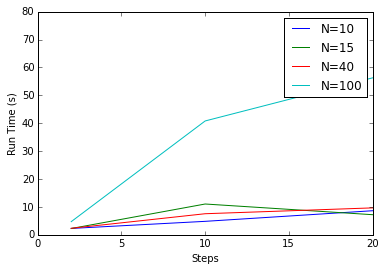

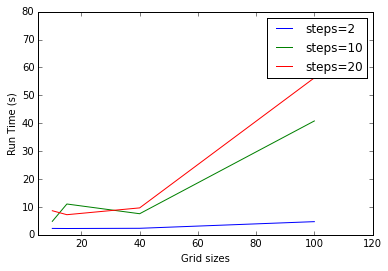

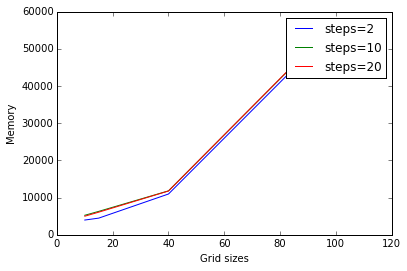

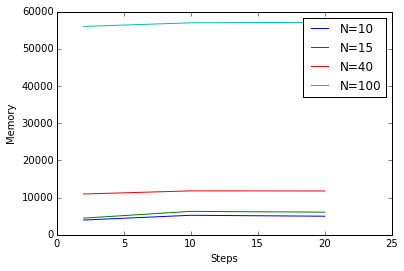

In [12]:
import matplotlib.pyplot as plt

#The first graph is plotting all the points
ax = df_N10.plot('steps', 'duration', kind='line', label='N={0}'.format(df_N10.N.iat[0]))
df_N15.plot('steps', 'duration', kind='line', ylim=0, ax=ax, label='N={0}'.format(df_N15.N.iat[0]))
# df_N20.plot('N', 'duration', kind='scatter', marker='o', s=10, ylim=0, ax=ax, label='N={0}'.format(df_N20.N.iat[0]))
# df_N30.plot('N', 'duration', kind='scatter', s=10, ylim=0, ax=ax, label='N={0}'.format(df_N30.N.iat[0]))
df_N40.plot('steps', 'duration', kind='line', ylim=0, ax=ax, label='N={0}'.format(df_N40.N.iat[0]))
df_N100.plot('steps', 'duration', kind='line', ax=ax,label='N={0}'.format(df_N100.N.iat[0]))

ax.set_xlim([0,20])
ax.set_ylim([0,80])
plt.ylabel('Run Time (s)')
plt.xlabel('Steps')
plt.legend()

#The second graph create lines for each steps size to see the evolution of 
# run duration with increasing grid sizes for the various step sizes
stepGraph = df_s2.plot('N', 'duration', kind='line', ylim=0, label='steps={0}'.format(df_s2.steps.iat[0]))
df_s10.plot('N', 'duration', kind='line', ylim=0, ax=stepGraph, label='steps={0}'.format(df_s10.steps.iat[0]))
df_s20.plot('N', 'duration', kind='line', ylim=0, ax=stepGraph, label='steps={0}'.format(df_s20.steps.iat[0]))

stepGraph.set_xlim([5,120])
stepGraph.set_ylim([0,80])
plt.ylabel('Run Time (s)')
plt.xlabel('Grid sizes')
plt.legend()


#MEMORY vs GRID SIZE Graphs
memoryGraph = df_s2.plot('N', 'memory', kind='line', ylim=0, label='steps={0}'.format(df_s2.steps.iat[0]))
df_s10.plot('N', 'memory', kind='line', ylim=0, ax=memoryGraph, label='steps={0}'.format(df_s10.steps.iat[0]))
df_s20.plot('N', 'memory', kind='line', ylim=0, ax=memoryGraph, label='steps={0}'.format(df_s20.steps.iat[0]))
plt.ylabel('Memory')
plt.xlabel('Grid sizes')
memoryGraph.set_xlim([0,120])
memoryGraph.set_ylim([0,60000])
plt.legend()

#MEMORY vs STEPS
memSteps = df_N10.plot('steps', 'memory', kind='line', label='N={0}'.format(df_N10.N.iat[0]))
df_N15.plot('steps', 'memory', kind='line', ylim=0, ax=memSteps, label='N={0}'.format(df_N15.N.iat[0]))
df_N40.plot('steps', 'memory', kind='line', ylim=0, ax=memSteps, label='N={0}'.format(df_N40.N.iat[0]))
df_N100.plot('steps', 'memory', kind='line', ax=memSteps,label='N={0}'.format(df_N100.N.iat[0]))
plt.ylabel('Memory')
plt.xlabel('Steps')
memSteps.set_xlim([0,25])
memSteps.set_ylim([0,60000])
plt.legend()